In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import math
from sklearn.neighbors import BallTree as BallTree
import matplotlib.pyplot as plt

In [2]:
bath = xr.open_dataset(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\ERA5_metOcean_bathy.nc')
depthNS = 20
shp_coast2 = pd.read_excel(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\Continental shapefile coordinates2.xlsx')
ERA5_on_coast = pd.read_excel(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\ERA5_locs_on_coast_fin.xlsx')
ERA5_around_coast = pd.read_excel(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\ERA5_coordinates_around_coast_fin.xlsx')
X1 = ERA5_on_coast.iloc[:,0]; Y1 = ERA5_on_coast.iloc[:,1]
X2 = ERA5_around_coast.iloc[:,0]; Y2 = ERA5_around_coast.iloc[:,1]
lfhs20 = pd.read_excel(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\lf_waveheight_lookuptable_d20.xlsx',header=None)
lftm20 = pd.read_excel(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\lf_waveperiod_lookuptable_d20.xlsx',header=None)
pi = math.pi
grav = 9.81
seasons = np.array(['DJF', 'MAM', 'JJA', 'SON'])

In [3]:
cols = ['lon', 'lat', 'depth0','shoreN','tm','tp','Ks','Kr','wind50','wind95','windAv','swh50','swh95','swhAv','ig50','ig95','igAv','wavePo','windAvUp','swhAvUp','igAvUp','operability','frequency','duration']
df = pd.DataFrame(columns = cols, index=range(0,4560))

In [4]:
# THRESHOLDS
Twind = 13.8
Twave = 2.0
Tig = 0.05

In [5]:
for i in range(1100,1101): #(0,4560)
    print(i)
    # LOAD ERA5 DATA
    ds = xr.open_dataset(r'c:\Users\wiegel\OneDrive - Stichting Deltares\Documents\input\ERA5_output_world_coast\Loc%s.nc' % i)
    dfx = ds.to_dataframe()
    dfx = dfx.dropna()
    if dfx.empty: continue
    
    dfx['season'] = seasons[(dfx.index.month // 3) % 4]
    df.loc[i].lon = dfx.longitude[0]
    df.loc[i].lat = dfx.latitude[0]
    
    # DEPTH OFFSHORE
    depth = bath.sel(latitude=dfx.latitude[0], longitude=dfx.longitude[0], method='nearest')
    depth = depth.to_dataframe()
    df['depth0'].loc[i] = depth.wmb[0]
    if np.isnan(df.loc[i].depth0) or df.loc[i].depth0 <= depthNS: df.loc[i].depth0 = depthNS
     
    # SHORENORMAL ORIENTATION
    F = np.array([df.loc[i].lon,df.loc[i].lat]).reshape(1,-1)
    x1 = shp_coast2.iloc[:,0].tolist()
    y1 = shp_coast2.iloc[:,1].tolist()
    X = np.column_stack((x1,y1))
    tree = BallTree(X, leaf_size=100)             
    dist, ind = tree.query(F, k=1)
    Cordmin = (X[ind-4]+X[ind-3]+X[ind-2]+X[ind-1])/4
    Cordpls = (X[ind+4]+X[ind+3]+X[ind+2]+X[ind+1])/4
    coastcoord = (Cordmin+Cordpls)/2
    theta = math.atan2((df.loc[i].lon - coastcoord[0,0,0]),(df.loc[i].lat - coastcoord[0,0,1]))
    shoreN = (theta*180/(math.pi)) % 360
    if np.isnan(shoreN):
        theta = math.atan2(X2[i]-X1[i],Y2[i]-Y1[i])
        shoreN = (theta*180/(math.pi)) % 360
    df['shoreN'].loc[i] = shoreN
    
    # WIND
    wind = np.sqrt(dfx.u10**2 + dfx.v10**2); wind[-1] = 0; wind[0] = 0
    dfx['wind'] = wind
    df['wind50'].loc[i] = wind.quantile([0.50]).iloc[0]
    df['wind95'].loc[i] = wind.quantile([0.95]).iloc[0]
    df['windAv'].loc[i] = np.count_nonzero(wind < Twind)/len(wind)*100
    idx = np.argwhere(np.diff(np.sign(Twind - wind))).flatten()
    Events = idx.reshape(len(idx)//2,2)
    if idx.size != 0:
        IntervalIndex = np.column_stack((Events[:-1,1],Events[1:,0]))
        ShortIntervalIndex = IntervalIndex[Events[1:,0]-Events[:-1,1] <= 4]
        for n in range(0,len(ShortIntervalIndex)):
            x = np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)
            wind[x] = Twind
        dfx.wind = wind
        df.loc[i].windAvUp = np.count_nonzero(wind < Twind)/len(wind)*100
    else:
        df.loc[i].windAvUp = 100
        
    # NEARSHORE TRANSLATION
    dirWave = dfx.mwd
    waveHeight = dfx.swh    
    wavePeriod = dfx.mwp
    peakPeriod = dfx.pp1d
    dirWave = dirWave * 1.
    waveHeight = waveHeight.astype('float')
    wavePeriod = wavePeriod * 1.
    depthOffshore = float(df.loc[i].depth0)
    depthNearshore = float(depthNS)
    shoreNormal = float(shoreN % 360)
    df.loc[i].tp = np.mean(peakPeriod)
    
    # WAVE LENGHT/NUMBER (DEEP & NEAR) BASED ON THE WAVE PERIOD WHICH REMAINS CONSTANT
    # Calculation based on the Matlab function disper.m and transformed to nearshore
    
    w2 = (2 * pi / wavePeriod)**2 * depthOffshore / grav
    q = w2 / ( (1 - np.exp(-(w2**(5/4))))**(2/5))
    for j in range(2):
        thq = np.tanh(q)
        thq2 = 1 - thq**2
        a = (1 - q * thq)*thq2
        b = thq + q * thq2
        c = q * thq - w2
        arg = b**2 - (4*a*c)
        arg = (-b + np.sqrt(arg)) / (2 * a)
        iq = np.abs(a * c) < (10**-8 * b**2)
        arg[iq] = - c[iq] / b[iq]
        q = q + arg
    k = q / depthOffshore
    Ldeep = 2 * pi / k
    
    # Nearshore depth wave number and wave length calculation via dispersion relation
    w3 = (2 * pi / wavePeriod)**2 * depthNearshore / grav
    q1 = w3 / (1 - np.exp(-(w3**(5/4))))**(2/5)
    for m in range(2):
        thq = np.tanh(q1)
        thq2 = 1 - thq**2
        a = (1 - q1 * thq)*thq2
        b = thq + q1 *thq2
        c = q1 * thq - w3
        arg = b**2 - (4*a*c)
        arg = (-b + np.sqrt(arg)) / (2 * a)
        iq = np.abs(a * c) < (10**-8 * b**2)
        arg[iq] = - c[iq] / b[iq]
        q1 = q1 + arg
    k1 = q1 / depthNearshore
    Lnear = 2 * pi / k1
  
    # Calculate the waveVelocity (deep and near)
    Cdeep = ((grav/k) * np.tanh(k * depthOffshore))**0.5
    Cnear = ((grav/k1) * np.tanh(k1 * depthNearshore))**0.5
    
    # Calculate the wave-angle of the point offshore
    relDir = (dirWave - shoreNormal + 180.) % 360. - 180.
    SinThetadeep = np.sin(relDir * (pi/180.))
    
    # Calculate the wave-angle of the point near the coast
    SinThetanear = (SinThetadeep / Cdeep) * Cnear
    relDirnear = np.arcsin(SinThetanear) * (180./pi)
    
    # Refraction coefficient
    Kr = (np.cos(relDir * (pi/180.)) / np.cos(relDirnear * (pi/180.)))**0.5
    Kr[(Kr < 0.8)] = 0.8
    df.loc[i].Kr = np.mean(Kr)
    
    # Calculate group wave velocities
    waveNumberdeep = 2*pi / Ldeep
    if depthOffshore/Ldeep.any() > 0.5: ndeep = 0.5
    else: ndeep = 0.5 * (1 + (2 * waveNumberdeep * depthOffshore) / np.sinh(2 * waveNumberdeep * depthOffshore))
    waveVelocitydeep = ( (grav*Ldeep / (2*pi)) * np.tanh(2*pi * depthOffshore / Ldeep) )**0.5
    Cgroupdeep = ndeep * waveVelocitydeep
    waveNumbernear = 2*pi / Lnear
    nnear = 0.5 * (1 + (2 * waveNumbernear * depthNearshore) / np.sinh(2 * waveNumbernear * depthNearshore))
    waveVelocitynear = ( (grav*Lnear / (2*pi)) * np.tanh(2*pi * depthNearshore / Lnear) )**0.5
    Cgroupnear = nnear * waveVelocitynear
    
    # Shoaling coefficient:
    Ks = (Cgroupdeep / Cgroupnear) ** 0.5
    df.loc[i].Ks = np.mean(Ks)
    
    # Wave-climate of the near shore
    waveHeightnearAlldir = Ks * waveHeight
    waveHeightnearAlldir[waveHeightnearAlldir > (depthNearshore*0.73)] = depthNearshore*0.73
    dfx['swh_nr_ad'] = waveHeightnearAlldir
    waveHeightnearReldir = Kr * Ks * waveHeight
    waveHeightnearReldir[waveHeightnearReldir > (depthNearshore*0.73)] = depthNearshore*0.73
    dfx['swh_nr_rd'] = waveHeightnearReldir
    wavePeriodnear = wavePeriod * 1.
    df.loc[i].tm = np.mean(wavePeriodnear)
    ixD = ~((-90 < relDir) & (relDir < 90))
    waveHeightnearReldir[ixD] = float('NaN')
    waveHeightnearReldir[ixD] = float('NaN')
    relDirnear[ixD] = relDir[ixD]
    df['swh50'].loc[i] = waveHeightnearReldir.quantile([0.5]).iloc[0]
    df['swh95'].loc[i] = waveHeightnearReldir.quantile([0.95]).iloc[0]
    waveHeightnearReldir = waveHeightnearReldir.fillna(0)
    df['swhAv'].loc[i] = np.count_nonzero(waveHeightnearReldir < Twave)/len(waveHeightnearReldir)*100
    waveHeightnearReldir[-1] = 0; waveHeightnearReldir[0] = 0
    idx = np.argwhere(np.diff(np.sign(Twave - waveHeightnearReldir))).flatten()
    Events = idx.reshape(len(idx)//2,2)
    if idx.size != 0:
        IntervalIndex = np.column_stack((Events[:-1,1],Events[1:,0]))
        ShortIntervalIndex = IntervalIndex[Events[1:,0]-Events[:-1,1] <= 4]
        for n in range(0,len(ShortIntervalIndex)):
            x = np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)
            waveHeightnearReldir[x] = Twave
        dfx.swh_nr_rd = waveHeightnearReldir
        df.loc[i].swhAvUp = np.count_nonzero(waveHeightnearReldir < Twave)/len(waveHeightnearReldir)*100
    else:
        df.loc[i].swhAvUp = 100
   
    # Infragravity (bound) waves nearshore
    idhs = (dfx.swh_nr_ad * 20).round().astype(int)
    idhs[idhs > 249]=249
    idtp = (peakPeriod * 10).round().astype(int)
    idtp[idtp > 249]=249
    lfhs = np.array(lfhs20)
    lftm = np.array(lftm20)
    lfhs = lfhs[idhs,idtp]
    lftm = lftm[idhs,idtp]
    lfhs[-1] = 0; lfhs[0] = 0
    dfx['lfhs'] = lfhs
    dfx['lftm'] = lftm
    df['ig50'].loc[i] = dfx.lfhs.quantile([0.50]).iloc[0]
    df['ig95'].loc[i] = dfx.lfhs.quantile([0.95]).iloc[0]
    df['igAv'].loc[i] = np.count_nonzero(lfhs < Tig)/len(lfhs)*100
    idx = np.argwhere(np.diff(np.sign(Tig - lfhs))).flatten()
    Events = idx.reshape(len(idx)//2,2)
    if idx.size != 0:
        IntervalIndex = np.column_stack((Events[:-1,1],Events[1:,0]))
        ShortIntervalIndex = IntervalIndex[Events[1:,0]-Events[:-1,1] <= 4]
        for n in range(0,len(ShortIntervalIndex)):
            lfhs[np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)] = Tig
        dfx.lfhs = lfhs
        df.loc[i].igAvUp = np.count_nonzero(lfhs < Tig)/len(lfhs)*100
    else:
        df.loc[i].igAvUp = 100
    
    # Longshore Sediment Transport potential
    dfx['wavePo'] = waveHeightnearAlldir**2.5*np.sin(2*SinThetanear)
    df['wavePo'].loc[i] = np.sum(np.abs(dfx.wavePo))/len(waveHeightnearAlldir)
    
    #Calculate the operability
    dfy = pd.concat([dfx.wind >= Twind, dfx.swh_nr_rd >= Twave, dfx.lfhs >= Tig], axis=1)
    persistence = dfy.sum(axis=1); persistence[-1]=0; persistence[0]=0
    idx3 = np.argwhere(np.diff(persistence > 0)).flatten()
    Events3 = idx3.reshape(len(idx3)//2,2)
    if idx3.size != 0:
        IntervalIndex = np.column_stack((Events3[:-1,1],Events3[1:,0]))
        ShortIntervalIndex = IntervalIndex[Events3[1:,0]-Events3[:-1,1] <= 4]
        for n in range(0,len(ShortIntervalIndex)):
            persistence[np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)] = 4
        dfx['persistence'] = persistence
    #dfz = dfy[dfy.wind | dfy.swh_nr_rd | dfy.lfhs]
    df['operability'].loc[i] = (len(dfy.index) - len(dfx.persistence.loc[~(dfx.persistence==0)]))/len(dfy.index)*100
    
    #Calculate the frequency (per year) shut down and restart again limits the uptime
    freq = dfy.sum(axis=1); freq[-1]=0; freq[0]=0
    if np.sum(freq) != 0:
        idx2 = np.argwhere(np.diff(freq > 0)).flatten()
        df['frequency'].loc[i] = len(idx2.reshape(len(idx2)//2,2))/40
    
    #Calculate the duration (per event) short periods could be caught up more quickly
        Events2 = idx2.reshape(len(idx2)//2,2)
        df['duration'].loc[i] = np.sum(Events2[:,1]-Events2[:,0])/len(Events2)
    else: df['frequency'].loc[i] = 0; df['duration'].loc[i] = 0

1100


In [6]:
df

,lon,lat,depth0,shoreN,tm,tp,Ks,Kr,wind50,wind95,...,ig50,ig95,igAv,wavePo,windAvUp,swhAvUp,igAvUp,operability,frequency,duration
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.loc[1100]

lon                  -55
lat                   50
depth0           230.047
shoreN           341.071
tm                7.0598
tp               8.83888
Ks              0.948789
Kr              0.929288
wind50           7.34566
wind95           14.0094
windAv           94.4867
swh50            1.32565
swh95            3.23271
swhAv             83.114
ig50             0.01655
ig95           0.0927885
igAv             84.7036
wavePo           3.99112
windAvUp         94.2584
swhAvUp          82.9794
igAvUp           84.5304
operability      79.7031
frequency         52.275
duration         27.0646
Name: 1100, dtype: object

In [143]:
len(dfz.index)

77788

In [150]:
persistence = dfy.sum(axis=1); persistence[-1]=0; persistence[0]=0
idx3 = np.argwhere(np.diff(persistence > 0)).flatten()
Events3 = idx3.reshape(len(idx3)//2,2)
if idx3.size != 0:
        IntervalIndex = np.column_stack((Events3[:-1,1],Events3[1:,0]))
        ShortIntervalIndex = IntervalIndex[Events3[1:,0]-Events3[:-1,1] <= 4]
        for n in range(0,len(ShortIntervalIndex)):
            persistence[np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)] = 4
        dfx['persistence'] = persistence
len(dfx.persistence.loc[~(dfx.persistence==0)])

In [152]:
len(dfx.persistence.loc[~(dfx.persistence==0)])

77879

In [148]:
len(dfu.loc[~(dfu==0)])-len(dfz.index)

91

In [149]:
91/350000

0.00026

In [73]:
persistence[np.arange(ShortIntervalIndex[n,0]+1,ShortIntervalIndex[n,1]+1)]

time
1979-01-01 01:00:00    3
1979-01-01 02:00:00    2
dtype: int64

In [20]:
idx = np.argwhere(np.diff(np.sign(Tig - lfhs))).flatten()
Events = idx.reshape(len(idx)//2,2)

109995

In [17]:
dfz

,wind,swh_nr_rd,lfhs
time,,,
1979-01-01 01:00:00,True,True,True
1979-01-01 02:00:00,True,True,True
1979-01-01 03:00:00,True,True,True
1979-01-01 04:00:00,True,True,True
1979-01-01 05:00:00,True,True,True
...,...,...,...
2018-12-31 18:00:00,False,True,True
2018-12-31 19:00:00,False,True,True
2018-12-31 20:00:00,False,True,True


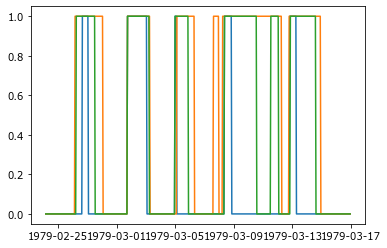

In [12]:
plt.plot(dfy[1300:1800])

In [11]:
df.to_excel('output_run20_4560locs_d20_w138_s_2_i_005.xlsx')

In [41]:
#Cgroupnear = nnear * waveVelocitynear
nnear = 0.5 * (1 + (2 * waveNumbernear * 20) / np.sinh(2 * waveNumbernear * 20))
nnear

time
1979-01-01 00:00:00    0.718004
1979-01-01 01:00:00    0.719360
1979-01-01 02:00:00    0.721527
1979-01-01 03:00:00    0.723925
1979-01-01 04:00:00    0.726338
                         ...   
2018-12-31 19:00:00    0.702513
2018-12-31 20:00:00    0.704877
2018-12-31 21:00:00    0.707997
2018-12-31 22:00:00    0.710903
2018-12-31 23:00:00    0.715135
Name: mwp, Length: 350640, dtype: float64

In [34]:
Cnear = ((grav/k1) * np.tanh(k1 * 15))**0.5
Cnear

time
1979-01-01 00:00:00    10.811790
1979-01-01 01:00:00    10.820829
1979-01-01 02:00:00    10.835183
1979-01-01 03:00:00    10.850941
1979-01-01 04:00:00    10.866672
                         ...    
2018-12-31 19:00:00    10.705351
2018-12-31 20:00:00    10.721984
2018-12-31 21:00:00    10.743719
2018-12-31 22:00:00    10.763739
2018-12-31 23:00:00    10.792525
Name: mwp, Length: 350640, dtype: float64

In [36]:
Cnear = ((grav/k1) * np.tanh(k1 * 20))**0.5
Cnear

time
1979-01-01 00:00:00    11.659036
1979-01-01 01:00:00    11.673114
1979-01-01 02:00:00    11.695513
1979-01-01 03:00:00    11.720170
1979-01-01 04:00:00    11.744858
                         ...    
2018-12-31 19:00:00    11.494987
2018-12-31 20:00:00    11.520418
2018-12-31 21:00:00    11.553764
2018-12-31 22:00:00    11.584592
2018-12-31 23:00:00    11.629112
Name: mwp, Length: 350640, dtype: float64

In [19]:
Cnear

time
1979-01-01 00:00:00    10.811790
1979-01-01 01:00:00    10.820829
1979-01-01 02:00:00    10.835183
1979-01-01 03:00:00    10.850941
1979-01-01 04:00:00    10.866672
                         ...    
2018-12-31 19:00:00    10.705351
2018-12-31 20:00:00    10.721984
2018-12-31 21:00:00    10.743719
2018-12-31 22:00:00    10.763739
2018-12-31 23:00:00    10.792525
Name: mwp, Length: 350640, dtype: float64

In [7]:
wavePeriod = 10
depthNearshore = 15
grav = 9.81
w3 = (2 * np.pi / wavePeriod)**2 * depthNearshore / grav
q1 = w3 / (1 - np.exp(-(w3**(5/4))))**(2/5)
for m in range(2):
    thq = np.tanh(q1)
    thq2 = 1 - thq**2
    a = (1 - q1 * thq)*thq2
    b = thq + q1 *thq2
    c = q1 * thq - w3
    arg = b**2 - (4*a*c)
    arg = (-b + np.sqrt(arg)) / (2 * a)
    iq = np.abs(a * c) < (10**-8 * b**2)
    arg = - c / b
    q1 = q1 + arg
k1 = q1 / depthNearshore
Lnear = 2 * np.pi / k1
Lnear

109.04953630153253

In [8]:
depthNearshore/Lnear

0.13755216673754161

In [23]:
depthNS


15

In [24]:
Ldeep

time
1979-01-01 00:00:00    145.064011
1979-01-01 01:00:00    146.069443
1979-01-01 02:00:00    147.694469
1979-01-01 03:00:00    149.519961
1979-01-01 04:00:00    151.387472
                          ...    
2018-12-31 19:00:00    134.175347
2018-12-31 20:00:00    135.769538
2018-12-31 21:00:00    137.909758
2018-12-31 22:00:00    139.940687
2018-12-31 23:00:00    142.966171
Name: mwp, Length: 350640, dtype: float64

In [25]:
Lnear

time
1979-01-01 00:00:00    104.215716
1979-01-01 01:00:00    104.663695
1979-01-01 02:00:00    105.383900
1979-01-01 03:00:00    106.187390
1979-01-01 04:00:00    107.003408
                          ...    
2018-12-31 19:00:00     99.241390
2018-12-31 20:00:00     99.984317
2018-12-31 21:00:00    100.973574
2018-12-31 22:00:00    101.903899
2018-12-31 23:00:00    103.275050
Name: mwp, Length: 350640, dtype: float64

In [27]:
depthNS/Lnear

time
1979-01-01 00:00:00    0.143932
1979-01-01 01:00:00    0.143316
1979-01-01 02:00:00    0.142337
1979-01-01 03:00:00    0.141260
1979-01-01 04:00:00    0.140182
                         ...   
2018-12-31 19:00:00    0.151147
2018-12-31 20:00:00    0.150024
2018-12-31 21:00:00    0.148554
2018-12-31 22:00:00    0.147198
2018-12-31 23:00:00    0.145243
Name: mwp, Length: 350640, dtype: float64